In [1]:
#Imports
import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from scipy.io import loadmat
from scipy.optimize import minimize

import displayData as disp
import checkNNGradients as grad
RANDOM_STATE = 100

### Función de coste (con y sin regularización) y sigmoide

In [2]:
def func_coste_reg(Thetas, X, Y, lmb):
    m = np.shape(X)[0]
    return cost_funct(Y, X, m) + regularizacion(Thetas, lmb, m)

def sigmoid_funct(z):
    return 1.0 / (1.0 + np.exp(-z))

def cost_funct(Y, g, m):
    J = np.sum(-1.0*Y* np.log(g) -1.0*(1 - Y)* np.log(1-g))
    return J/m

def regularizacion(Thetas, lmb, m):
    suma = 0
    for i in Thetas:
        i = i[:,1:]
        suma += (np.sum(i**2))
    
    return (lmb/(2*m))*suma


### Propagación hacia delante

In [3]:
def forward_propagation(X, theta1, theta2, m, Y):
    
    #Capa entrada asignamos la X con los unos incluidos
    a1 = np.hstack([np.ones([m, 1]), X])

    #capa intermedia (hidden) calculamos las ecuaciones de la anterior, aplicamos la sigmoide e incluimos los unos de la neurona 0 
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid_funct(z2)])

    #Capa salida calcuamos las ecuaciones con theta2 y aplicamos la sigmoide, nos devuelve la matriz de salida 5000x10
    z3 = np.dot(a2, theta2.T)
    
    a3 = sigmoid_funct(z3)
    
    return a1, z2, a2, z3, a3

### Propagación hacia atrás

In [4]:

def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, reg):

    #Recostruimos las Thetas
    Theta1 = np.reshape(params_rn[:num_ocultas *(num_entradas + 1)],(num_ocultas, (num_entradas+1)))
    Theta2 = np.reshape(params_rn[num_ocultas*(num_entradas + 1): ], (num_etiquetas,(num_ocultas+1)))
    
    m = X.shape[0]    
    y_onehot = Y
    
    a1, z2, a2, z3, a3 = forward_propagation(X, Theta1, Theta2, m, y_onehot)
    
    #Calculamos el coste
    coste = func_coste_reg([Theta1, Theta2], a3, y_onehot, reg)


    d3 = a3 - y_onehot
    d2 = np.matmul(Theta2.T,d3.T)*(a2*(1-a2)).T
    
    #Calculamos los gradientes no regularizados
    G1 = np.matmul(d2[1:,:], a1)/m
    G2 = np.matmul(d3.T,a2)/m
    
    #Calculamos los gradientes regularizados
    G1 = G1 + ((reg*1.0)/m)*np.insert(Theta1[:, 1:], 0, 0, axis = 1)
    G2 = G2 + ((reg*1.0)/m)*np.insert(Theta2[:, 1:], 0, 0, axis = 1)

    #Ponemos los gradientes en forma de lista
    gradientes = np.concatenate((G1, G2), axis = None)
    
    return coste, gradientes

### Función que optimiza los pesos de la red neuronal

In [5]:
#Genera los pesos aleatorios
def RandomWeights(entradas, salidas, ini):
    Theta = np.random.uniform(-ini, ini, size = (salidas,entradas+1))
    return Theta

In [6]:
def optimize_backprop_and_check (num_entradas, num_ocultas, num_etiquetas, reg, X, y_onehot, laps, Y, ini):
    
    #Inicializamos los pesos y los ponemos en forma de lista
    Theta1 = RandomWeights(num_entradas, num_ocultas, ini)
    Theta2 = RandomWeights(num_ocultas, num_etiquetas, ini)
    pesos = np.concatenate((Theta1, Theta2), axis=None)

    #Optimizamos
    out = opt.minimize(fun = backprop, x0 = pesos, args = (num_entradas, num_ocultas, num_etiquetas, X, y_onehot, reg), method='TNC', jac = True, options = {'maxiter': laps})

    #Reconstruimos las Thetas
    Theta1 = out.x[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
    Theta2 = out.x[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))
    
    m = X.shape[0]
    #Hacemos el forward propagation
    a1, z2, a2, z3, a3 = forward_propagation(X, Theta1, Theta2, m, y_onehot)
    
    #Sacamos los aciertos
    indexes = np.argmax(a3, axis=1)
    acc = (np.sum(indexes == (Y))/m)*100
    
    print("Porcentaje aciertos: ", acc)
    return acc

### Punto de entrada (main)

In [13]:
def main():
    
    data = loadmat ("ex4data1.mat")

    #almacenamos los datos leídos en X e y
    X = data['X']
    m = X.shape[0]
    #X = np.hstack([np.ones([m, 1]), X])
    y = data['y']
    y = np.ravel(y) 
    num_labels = 10
    num_entries = np.shape(X)[1]
    num_hiden_layers = 25

    disp.displayImage(X[4])
    
    #Ponemos la y en forma onehot
    y = y-1
    y_onehot = np.zeros((m, num_labels))  # 5000 x 10
    
    for i in range(m):
        y_onehot[i][y[i]] = 1
    
    #Cargamos los pesos de prueba 
    weights = loadmat("ex4weights.mat")
    theta1, theta2 = weights["Theta1"], weights["Theta2"]

    reg = 1
    a1, z2, a2, z3, a3 = forward_propagation(X, theta1, theta2, m, y_onehot)
    
    print("Coste no regularizado: ",cost_funct(y_onehot, a3, m))
    print("Coste regularizado: ",func_coste_reg([theta1, theta2], a3,y_onehot, reg))
    
    #Check del gradiente con reg
    print(grad.checkNNGradients(backprop, reg))
    
    
    acc = optimize_backprop_and_check(num_entries, num_hiden_layers, num_labels, reg, X, y_onehot, 70, y, 0.12)
   
    #Pruebas
    '''l = [0,0.05,0.1, 0.25, 0.5, 1,2 ,3 ,4, 5,10,20,100]
    g = [30, 50, 70, 100, 200, 300]
    for i in g:
        print("iteraciones: " ,i)
        for j in range (0, 5):
            acc = optimize_backprop_and_check(num_entries, num_hiden_layers, num_labels, reg, X, y_onehot, i, y, 0.12)
            
    for i in l:
        print("Lambda: " ,i)
        for j in range (0, 5):
            acc = optimize_backprop_and_check(num_entries, num_hiden_layers, num_labels, i, X, y_onehot, 70, y, 0.12)
    '''
    return acc

Coste no regularizado:  0.2876291651613189
Coste regularizado:  0.38376985909092365
grad shape:  (38,)
num grad shape:  (38,)
[ 5.49965629e-11  7.32747196e-13  8.82988127e-12  7.53046930e-12
 -6.08260664e-11  2.10970130e-12 -1.38742212e-11 -4.70332939e-11
 -9.29989974e-11  7.81530396e-12 -4.12793411e-11 -1.26643918e-10
 -2.40059500e-11  4.35645964e-12 -7.00919878e-12 -2.43030734e-11
  2.15736456e-11  2.27595720e-13  7.55695506e-12  2.84505197e-11
  6.25964836e-11  1.38673517e-11  4.06508160e-12  3.07234793e-12
  1.58902475e-11  1.33972833e-11  6.93309299e-11  1.41544554e-11
  7.86469501e-12  1.17110766e-11  1.64833147e-11  1.95246597e-11
  7.32915950e-11  1.66865410e-11  6.33046393e-12  1.85329807e-11
  1.79033732e-11  1.99839867e-11]
Porcentaje aciertos:  93.76


93.76

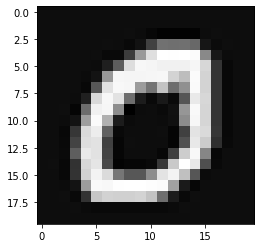

In [16]:
main()